<a href="https://colab.research.google.com/github/neonithinar/What-Language-is-this-/blob/main/Language_Identification_Project_preliminary_try_out.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Language identification using N-grams
 Particularly we will be using trigrams for this project. That is 3 consequtive words that occur in the language. As suggested by many literary works n-grams are a very efficient way to identify the language.
  This [dataset](https://downloads.tatoeba.org/exports/sentences.csv) is hosted by Tatoeba 

In [ ]:
# Common Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [ ]:
# Download the dataset
! wget https://downloads.tatoeba.org/exports/sentences.csv

--2021-02-02 17:18:18--  https://downloads.tatoeba.org/exports/sentences.csv
Resolving downloads.tatoeba.org (downloads.tatoeba.org)... 94.130.77.194
Connecting to downloads.tatoeba.org (downloads.tatoeba.org)|94.130.77.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 507415742 (484M) [application/octet-stream]
Saving to: ‘sentences.csv’

sentences.csv       100%[===================>] 483.91M  20.7MB/s    in 25s     

2021-02-02 17:18:43 (19.7 MB/s) - ‘sentences.csv’ saved [507415742/507415742]



In [ ]:
#read data
df = pd.read_csv("sentences.csv", sep= '\t', encoding= 'utf8', index_col= 0, names=['lang', 'text'])
length_condition = [True if 20 <= len(sen) <= 200 else False for sen in df['text']]

df = df[length_condition]


In [ ]:
df['lang'].unique()

array(['cmn', 'deu', 'rus', 'fra', 'eng', 'spa', 'ita', 'jpn', 'kor',
       'vie', 'nld', 'epo', 'por', 'tur', 'heb', 'ell', 'ind', 'ara',
       'arz', 'fin', 'bul', 'swe', 'ukr', 'bel', 'que', 'ces', 'nno',
       'nob', 'zsm', 'est', 'kat', 'pol', 'lat', 'yue', 'swh', 'sqi',
       'hun', 'isl', 'wuu', 'fry', 'afr', 'ron', 'fao', 'san', 'bre',
       'tat', 'yid', 'uig', 'uzb', 'srp', 'qya', 'pes', nan, 'slk', 'eus',
       'cycl', 'dan', 'acm', 'lvs', 'kaz', 'hye', 'hin', 'ben', 'cat',
       'bos', 'hrv', 'lit', 'tha', 'urd', 'orv', 'cha', 'tgl', 'mon',
       'scn', 'gle', 'slv', 'frm', 'glg', 'vol', 'jbo', 'toki', 'ina',
       'nds', 'mal', 'tlh', 'roh', 'lzh', 'ltz', 'oss', 'ido', 'gla',
       'mlt', 'ast', 'oci', 'ile', 'ota', 'xal', 'tel', 'sjn', 'nov',
       'khm', 'tpi', 'ang', 'aze', 'tgk', 'tuk', 'chv', 'mkd', 'hsb',
       'dsb', 'sme', 'cym', 'mri', 'ksh', 'kmr', 'ewe', 'ber', 'udm',
       'lld', 'pms', 'lad', 'grn', 'mlg', 'xho', 'pnb', 'grc', 'npi',
       'tpw',

There are 328 unique languages in this dataset. Taking only a few latin languages for simplicity (precisely some languages as the europarl dataset which we will later encounter)

In [ ]:
languages = ['deu', 'eng', 'fra', 'ita', 'por', 'spa' ]
df = df[df['lang'].isin(languages)]
# df.info()
# df.head()
# df['lang'].unique()



# trim the dataset
df_trim = pd.DataFrame(columns=['lang', 'text'])

for l in languages:
  lang_trim = df[df['lang'] == l].sample(50000, random_state = 42)
  df_trim = df_trim.append(lang_trim)

# Create random train, val, and test set

df_shuffle = df_trim.sample(frac = 1)
df_shuffle.shape


(300000, 2)

In [ ]:
train_set = df_shuffle[:210000]
validation_set = df_shuffle[210000: 270000]
test_set = df_shuffle[270000:300000]


In [ ]:
train_set.shape

(210000, 2)

In [ ]:
# Let's save the data
# train_set.to_csv('../data/train.csv')
# validation_set.to_csv('../data/valid.csv')
# test_set.to_csv('../data/test.csv')

# Feature Engineering


In [ ]:
print(len(train_set), len(validation_set), len(test_set))

210000 60000 30000


In [ ]:
train_set.head()

,lang,text
329974,spa,"¿Te gusta el béisbol, Bin?"
1400438,spa,¿Le cambio el agua a las flores?
2320878,spa,No sabía que te alojabas en este hotel.
6736771,fra,"Nous sommes impatients de vous voir, toi et ta..."
973056,spa,Él es tan buen golfista como vos.


In [ ]:
def get_trigrams(corpus, num_features = 200):
  """ Returns a list of N most commmon trigrams from a list of 
      sentences:
      corpus: List of strings
      num_features: (int) number of features
      """
  vectorizer = CountVectorizer(analyzer= "char", ngram_range= (3, 3), max_features= num_features)
  X = vectorizer.fit_transform(corpus)

  feature_names = vectorizer.get_feature_names()
  return feature_names


In [ ]:
# get Trigrams for each language

features = {}
feature_set = set()

for l in languages:
  corpus = train_set[train_set.lang == l]['text']
  # get 200 most frequent trigrams. (num of features can be changed by changing num_features)
  trigrams = get_trigrams(corpus)
  features[l] = trigrams
  feature_set.update(trigrams)

# create a vocabulary using feature set
vocab = dict()
for i, f in enumerate(feature_set):
  vocab[f] = i


In [ ]:
len(features['eng'])


200

In [ ]:
# train count vectorizer using the vocabulary
vectorizer = CountVectorizer(analyzer= 'char', ngram_range= (3, 3), vocabulary= vocab)

# create feature matrix for   training set
corpus = train_set['text']
X = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()
train_features = pd.DataFrame(data = X.toarray(), columns = feature_names)


In [ ]:
print(len(train_features.columns))
train_features

673


,r w,oin,t t,ted,peu,cu,or,ez,él,tru,sa,voc,va,n m,d h,re,ese,mit,ch,ein,a,"n,",du,in,end,ito,man,ant,nda,lo,mai,ca,i p,oro,a v,o i,oir,pia,per,uld,...,olt,ado,ux,go,ve,a t,m p,wh,n c,vi,m d,r i,cos,ann,e q,ica,au,e,zer,me,ada,se,mos,o s,ava,a f,m e,l'a,ois,ndo,pe,ri,all,con,eu,ti,ure,nge,ela,ery
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
209996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
209997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
209998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Scaling the feature matrix
train_min = train_features.min()
train_max = train_features.max()
train_features = (train_features - train_min) / (train_max - train_min)

# Add the target variable
train_features['lang'] = list(train_set['lang'])

train_features

,r w,oin,t t,ted,peu,cu,or,ez,él,tru,sa,voc,va,n m,d h,re,ese,mit,ch,ein,a,"n,",du,in,end,ito,man,ant,nda,lo,mai,ca,i p,oro,a v,o i,oir,pia,per,uld,...,ado,ux,go,ve,a t,m p,wh,n c,vi,m d,r i,cos,ann,e q,ica,au,e,zer,me,ada,se,mos,o s,ava,a f,m e,l'a,ois,ndo,pe,ri,all,con,eu,ti,ure,nge,ela,ery,lang
0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,spa
1,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,spa
2,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,spa
3,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fra
4,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,spa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209995,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ita
209996,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,eng
209997,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,por
209998,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fra


In [ ]:
def feature_matrix_scaled(df, train_min = train_min, train_max = train_max):
  corpus = df['text']
  X = vectorizer.fit_transform(corpus)
  df_feat = pd.DataFrame(data= X.toarray(), columns=feature_names)
  df_feat = (df_feat - train_min) / (train_max - train_min)
  # add target var
  df_feat['lang'] = list(df['lang'])
  return df_feat
  

In [ ]:
valid_feat = feature_matrix_scaled(validation_set)
valid_feat

,r w,oin,t t,ted,peu,cu,or,ez,él,tru,sa,voc,va,n m,d h,re,ese,mit,ch,ein,a,"n,",du,in,end,ito,man,ant,nda,lo,mai,ca,i p,oro,a v,o i,oir,pia,per,uld,...,ado,ux,go,ve,a t,m p,wh,n c,vi,m d,r i,cos,ann,e q,ica,au,e,zer,me,ada,se,mos,o s,ava,a f,m e,l'a,ois,ndo,pe,ri,all,con,eu,ti,ure,nge,ela,ery,lang
0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.25,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,eng
1,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,eng
2,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.000000,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,ita
3,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.25,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,spa
4,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,eng
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.2,0.0,0.0,0.0,0.000000,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.25,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,ita
59996,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,fra
59997,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,deu
59998,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.

In [ ]:
test_feat = feature_matrix_scaled(test_set)

In [ ]:
print(len(valid_feat.columns),len(test_feat.columns))
print(len(train_features),len(valid_feat),len(test_feat))

674 674
210000 60000 30000


# Exploratory Data Analysis

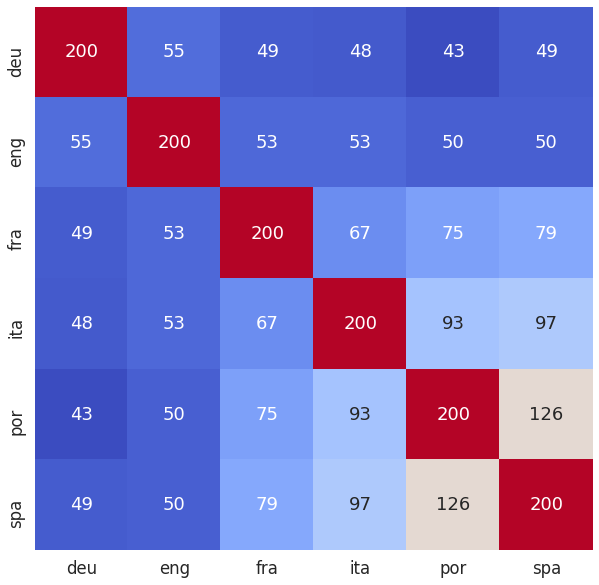

In [ ]:
#Calculate number of shared trigrams
labels = ['deu', 'eng', 'fra', 'ita', 'por', 'spa']

mat = []
for i in labels:
    vec = []
    for j in labels:
        l1 = features[i]
        l2 = features[j]
        intersec = [l for l in l1 if l in l2]


        vec.append(len(intersec))
    mat.append(vec)

#Plot heatmap
lang = ['deu', 'eng', 'fra', 'ita', 'por', 'spa']
conf_matrix_df = pd.DataFrame(mat,columns=lang,index=lang)


plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(conf_matrix_df,cmap='coolwarm',annot=True,fmt='.5g',cbar=False)



# plt.savefig('../figures/feat_explore.png',format='png',dpi=150)

# Modelling and Hyperparameter tuning

In [ ]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils

encoder = LabelEncoder()
encoder.fit(labels)

def encode(y):
  """ Returns a list of one hot encodings; 
  y = list of language labels"""
  y_encoded = encoder.transform(y)
  return np_utils.to_categorical(y_encoded)
  

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

X = train_features.drop('lang', axis= 1)
y = encode(train_features['lang'])

X_valid = valid_feat.drop('lang', axis= 1)
y_valid = encode(valid_feat['lang'])

X_test = test_set.drop('lang', axis = 1)
y_test = encode(test_set['lang'])

In [ ]:
X.shape

(210000, 673)

In [ ]:
num_features = train_features.shape[1]
# num_features
output_layer_shape = len(languages)
output_layer_shape

6

In [ ]:
num_features = train_features.shape
model_num = 1
def fit_model(nodes, epochs, batch_size, x = X, y = y, x_valid = X_valid, y_valid = y_valid):
  
  model = keras.models.Sequential([
                                   keras.layers.Dense(nodes[0], input_dim = 673, activation= 'relu'),
                                   keras.layers.Dense(nodes[1], activation= 'relu'), 
                                   keras.layers.Dense(nodes[2], activation= 'relu'),
                                   keras.layers.Dense(output_layer_shape, activation= 'softmax')
  ])
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  checkpoint_cb = keras.callbacks.ModelCheckpoint("model_keras.h5", save_best_only= True)
  early_stopping = keras.callbacks.EarlyStopping(patience= 3, restore_best_weights= True)
  history = model.fit(x, y, epochs=epochs, batch_size=batch_size, validation_data = (x_valid, y_valid), callbacks = [checkpoint_cb, early_stopping])
  # train_accuracy = model.evaluate(x, y)
  validation_accuracy = model.evaluate(x_valid, y_valid)


  return round(validation_accuracy[1]*100,2)

If you get error in the following code, take a look at the error message and it would normally look like expected dimension 664 got dimension (10, 655) This happens because on different runs, the top 200 trigrams encoded may differ because of the absence of the random_state attribute for the sampling variable.

In [ ]:
nodes = [[100,100,50],[200,200,100],[300,200,100],[500,500,250]]
# epochs = [1,2,3,4]
batch_size = [100,300]
epochs_list = [10, 20]

results = []
i = 0

for n in nodes:
    print("MODEL: ", i)
    for b in batch_size:
            result = {}
            
            result['model'] = i
            result['nodes'] = n
            # result['epochs'] = e
            result['batch_size'] = b
            result['valid'] = fit_model(nodes = n, batch_size= b, epochs= 5)
            
            results.append(result)
            i+= 1   

results_final = pd.DataFrame(results)

MODEL:  0
Epoch 1/5
2100/2100 [==============================] - 7s 3ms/step - loss: 0.2545 - accuracy: 0.9157 - val_loss: 0.0474 - val_accuracy: 0.9833
Epoch 2/5
2100/2100 [==============================] - 6s 3ms/step - loss: 0.0408 - accuracy: 0.9851 - val_loss: 0.0424 - val_accuracy: 0.9846
Epoch 3/5
2100/2100 [==============================] - 6s 3ms/step - loss: 0.0340 - accuracy: 0.9876 - val_loss: 0.0396 - val_accuracy: 0.9858
Epoch 4/5
2100/2100 [==============================] - 7s 3ms/step - loss: 0.0279 - accuracy: 0.9898 - val_loss: 0.0404 - val_accuracy: 0.9858
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0403 - accuracy: 0.9865
Epoch 1/5
700/700 [==============================] - 3s 4ms/step - loss: 0.4176 - accuracy: 0.8787 - val_loss: 0.0509 - val_accuracy: 0.9813
Epoch 2/5
700/700 [==============================] - 2s 4ms/step - loss: 0.0411 - accuracy: 0.9850 - val_loss: 0.0415 - val_accuracy: 0.9850
Epoch 3/5
700/700 [================

Final tuned model

In [ ]:
results_final[results_final.valid == results_final.valid.max()]

,model,nodes,batch_size,valid
7,7,"[500, 500, 250]",300,98.75


In [ ]:
results_final[results_final.valid > 98.5]

,model,nodes,batch_size,valid
0,0,"[100, 100, 50]",100,98.65
1,1,"[100, 100, 50]",300,98.62
2,2,"[200, 200, 100]",100,98.65
3,3,"[200, 200, 100]",300,98.62
4,4,"[300, 200, 100]",100,98.58
5,5,"[300, 200, 100]",300,98.61
6,6,"[500, 500, 250]",100,98.53
7,7,"[500, 500, 250]",300,98.75


# Modeling The finetuned Model

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
                                 keras.layers.Dense(500, input_dim = 673, activation = 'relu'), 
                                 keras.layers.Dense(500, activation = 'relu'),
                                 keras.layers.Dense(250, activation = 'relu'), 
                                 keras.layers.Dense(6, activation = 'softmax') 
])

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint("model_keras.h5", save_best_only= True)
early_stopping = keras.callbacks.EarlyStopping(patience= 3, restore_best_weights= True)


history = model.fit(X, y, epochs = 12, batch_size = 300, validation_data = (X_valid, y_valid), callbacks = [checkpoint_cb, early_stopping])
# model.evaluate(X_valid, y_valid)
model = keras.models.load_model("model_keras.h5")
model.evaluate(X_valid, y_valid)

Epoch 1/12
700/700 [==============================] - 3s 4ms/step - loss: 0.2299 - accuracy: 0.9367 - val_loss: 0.0526 - val_accuracy: 0.9815
Epoch 2/12
700/700 [==============================] - 3s 4ms/step - loss: 0.0365 - accuracy: 0.9871 - val_loss: 0.0416 - val_accuracy: 0.9853
Epoch 3/12
700/700 [==============================] - 3s 4ms/step - loss: 0.0242 - accuracy: 0.9913 - val_loss: 0.0406 - val_accuracy: 0.9867
Epoch 4/12
700/700 [==============================] - 3s 4ms/step - loss: 0.0144 - accuracy: 0.9950 - val_loss: 0.0380 - val_accuracy: 0.9878
Epoch 5/12
700/700 [==============================] - 3s 4ms/step - loss: 0.0083 - accuracy: 0.9973 - val_loss: 0.0473 - val_accuracy: 0.9868
Epoch 6/12
700/700 [==============================] - 3s 4ms/step - loss: 0.0068 - accuracy: 0.9976 - val_loss: 0.0517 - val_accuracy: 0.9870
Epoch 7/12
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0380 - accuracy: 0.9878


[0.0380072183907032, 0.9878333210945129]

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


evaluation time:  1.2689549922943115


Text(58.5, 0.5, 'Actual')

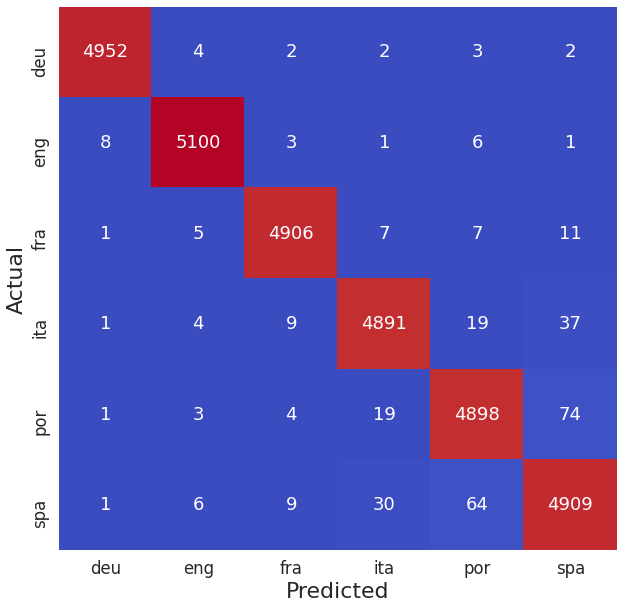

In [ ]:
import time
start_time = time.time()
x_test = test_feat.drop('lang',axis=1)
y_test = test_feat['lang']
label_predict = model.predict_classes(x_test)

predictions = encoder.inverse_transform(label_predict)
end_time = time.time()
print("evaluation time: ", end_time - start_time)
accuracy = accuracy_score(y_test, predictions)

#Create confusion matrix
lang = ['deu', 'eng', 'fra', 'ita', 'por', 'spa']
conf_matrix = confusion_matrix(y_test,predictions)
conf_matrix_df = pd.DataFrame(conf_matrix,columns=lang,index=lang)

#Plot confusion matrix heatmap
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(conf_matrix_df,cmap='coolwarm',annot=True,fmt='.5g',cbar=False)
plt.xlabel('Predicted',fontsize=22)
plt.ylabel('Actual',fontsize=22)

# plt.savefig('../figures/model_eval.png',format='png',dpi=150)